# 04 – Foraging policies on the two-hub landscape

In this notebook we simulate simple decision policies on top of the
two-hub configuration obtained in Notebook 03.

Each policy starts from a hub, has a limited travel budget and visits
customers one by one trying to collect importance (`w_importance`) while
respecting the distance constraint.

We compare heuristics such as:

- nearest neighbour (distance-based),
- greedy importance (value-based),
- importance-per-km ratio (value / distance).

The goal is not to build a full reinforcement learning agent, but to firstly
illustrate how different operational rules use the same hub–customer
landscape in different ways 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 140)

ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data"

PATH_CUSTOMERS_HUBS = DATA_DIR / "customers_north_with_hubs.csv"
PATH_HUBS = DATA_DIR / "hubs_north.csv"

PATH_CUSTOMERS_HUBS, PATH_HUBS

(WindowsPath('../data/customers_north_with_hubs.csv'),
 WindowsPath('../data/hubs_north.csv'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 140)

ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data"

PATH_CUSTOMERS_HUBS = DATA_DIR / "customers_north_with_hubs.csv"
PATH_HUBS = DATA_DIR / "hubs_north.csv"

PATH_CUSTOMERS_HUBS, PATH_HUBS

(WindowsPath('../data/customers_north_with_hubs.csv'),
 WindowsPath('../data/hubs_north.csv'))

In [3]:
df = pd.read_csv(PATH_CUSTOMERS_HUBS)
df_hubs = pd.read_csv(PATH_HUBS)

df.shape, df_hubs.shape

((63720, 30), (2, 3))

In [4]:
df.head()

,DSREG,CDCLIE,NROPUESUM,VVENTASPROM,LATTUD,LNGTUD,HUB,PESO POR SERVICIOS,CANTIDADEQ,EDADDIAS,Cantserviciosdistri,CantserviciosST,Cantidad total serv,TIEMPO DE EJECUCION PROMEDIO (MINUTOS),TIEMPO PROMEDIO DE LLAMADOS (DIAS),DEPARTAMENTO,DEPARTAMENTO OPTIMO,ZONA OPTIMA,Distancia_punto1_m,Distancia_punto2_m,Cantidad_total_serv,sales_norm,equip_norm,services_norm,w_importance,cluster_id,assigned_hub,dist_km_hub1,dist_km_hub2,dist_km_assigned
0,NORTE,6.156346e+06,2,23.817759,-8.150649,-79.841065,TRUJILLO,0,1,2522.513428,0,0,1,0.000000,0.379474,LA LIBERTAD,0.975740,NaN,13571,240357,0,0.036471,0.0,0.0,0.014588,0,HUB_1,62.410438,350.462203,62.410438
1,NORTE,6.050903e+06,1,47.631922,-9.152026,-78.772544,TRUJILLO,1,1,3169.428633,1,0,1,0.000000,0.857509,ANCASH,0.976667,NaN,14264,0,1,0.086140,0.0,0.2,0.094456,0,HUB_1,145.579647,460.649305,145.579647
2,NORTE,1.866376e+06,2,21.764656,-9.470377,-78.523142,TRUJILLO,0,1,799.794277,1,0,1,1569.841855,0.301505,ANCASH,0.003087,NaN,2964,283391,1,0.032189,0.0,0.2,0.072876,0,HUB_1,189.345384,499.798804,189.345384
3,NORTE,1.680596e+06,1,37.902756,-9.159700,-80.276835,TRUJILLO,1,1,1299.107842,2,0,1,124.375773,0.000000,CAJAMARCA,0.007660,NaN,113977,444422,2,0.065848,0.0,0.4,0.146339,0,HUB_1,171.008488,469.993321,171.008488
4,NORTE,7.936723e+06,1,52.424385,-6.774554,-80.288595,TRUJILLO,2,1,2903.683917,2,1,0,0.000000,0.264073,LA LIBERTAD,0.000000,NaN,194098,340663,3,0.096135,0.0,0.6,0.218454,0,HUB_1,169.982607,220.901328,169.982607


In [5]:
df_hubs

,LATTUD,LNGTUD,HUB_ID
0,-7.955357,-79.309625,HUB_1
1,-5.043573,-79.308496,HUB_2


In [6]:
# Default distance column: Haversine distance to assigned hub
distance_col = "dist_km_assigned"

# If you have road distances from OpenRouteService stored in another
# column (like "road_km_assigned"), you can switch it here ;) :
#
# distance_col = "road_km_assigned"

if distance_col not in df.columns:
    raise KeyError(f"Distance column '{distance_col}' not found in dataframe.")

distance_col

'dist_km_assigned'

In [7]:
df_north = df.copy()

base_cols = [
    "CDCLIE",
    "assigned_hub",
    "LATTUD",
    "LNGTUD",
    "w_importance",
    distance_col,
]

df_north[base_cols].head()

,CDCLIE,assigned_hub,LATTUD,LNGTUD,w_importance,dist_km_assigned
0,6.156346e+06,HUB_1,-8.150649,-79.841065,0.014588,62.410438
1,6.050903e+06,HUB_1,-9.152026,-78.772544,0.094456,145.579647
2,1.866376e+06,HUB_1,-9.470377,-78.523142,0.072876,189.345384
3,1.680596e+06,HUB_1,-9.159700,-80.276835,0.146339,171.008488
4,7.936723e+06,HUB_1,-6.774554,-80.288595,0.218454,169.982607


In [8]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

# I here defined the enviroment of foraging to test 

In [10]:
class ForagingEnv:
    """
    Very simple environment for hub-based routing ;)
    
    - We start at a chosen hub
    - We have a travel budget (in km), cuz this is what happens in real logistics
    - At each step we choose one unvisited customer to visit
    - Reward = w_importance of the visited customer
    - Cost = distance from current position to that customer

    The environment does not model time windows, capacity, etc.
    It is just a clean playground for comparing heuristic policies.
    """

    def __init__(self, df_customers, df_hubs, hub_id, distance_col, budget_km=400.0):
        # Keep only customers assigned to this hub
        self.customers = df_customers[df_customers["assigned_hub"] == hub_id].copy()
        self.customers = self.customers.reset_index(drop=True)

        # Hub coordinates
        hub_row = df_hubs[df_hubs["HUB_ID"] == hub_id].iloc[0]
        self.hub_lat = hub_row["LATTUD"]
        self.hub_lon = hub_row["LNGTUD"]

        self.distance_col = distance_col
        self.budget_km = float(budget_km)

        # State variables
        self.reset()

    def reset(self):
        """Reset the tour: start at the hub, nothing visited."""
        self.current_lat = self.hub_lat
        self.current_lon = self.hub_lon
        self.remaining_km = self.budget_km
        self.total_reward = 0.0
        self.total_distance = 0.0

        # All customers are initially unvisited
        self.customers["visited"] = False

        # We will store the path as a list of indices
        self.path = []
        return self._get_observation()

    def _get_observation(self):
        """Return a small snapshot of the current state (for logging)."""
        return {
            "current_lat": self.current_lat,
            "current_lon": self.current_lon,
            "remaining_km": self.remaining_km,
            "total_reward": self.total_reward,
            "total_distance": self.total_distance,
        }

    def step(self, customer_idx):
        """
        Visit a given customer index (in self.customers).

        Returns:
            obs, reward, done, info
        """
        if self.customers.loc[customer_idx, "visited"]:
            # Already visited; no movement, no reward (just to be safe)
            return self._get_observation(), 0.0, False, {"reason": "already_visited"}

        # Coordinates of the chosen customer
        row = self.customers.loc[customer_idx]
        lat = row["LATTUD"]
        lon = row["LNGTUD"]

        # Compute travel distance from current position
        travel_km = haversine_km(self.current_lat, self.current_lon, lat, lon)

        # If not enough budget to go, terminate
        if travel_km > self.remaining_km:
            return self._get_observation(), 0.0, True, {"reason": "budget_exhausted"}

        # Move to the customer
        self.current_lat = lat
        self.current_lon = lon
        self.remaining_km -= travel_km
        self.total_distance += travel_km

        # Collect reward (importance score)
        reward = row["w_importance"]
        self.total_reward += reward

        # Mark as visited and append to path
        self.customers.loc[customer_idx, "visited"] = True
        self.path.append(customer_idx)

        # Check if there are any unvisited customers that we could still reach
        unvisited = self.customers[~self.customers["visited"]]
        done = unvisited.empty

        return self._get_observation(), reward, done, {"travel_km": travel_km}

In [11]:
hub_ids = df_hubs["HUB_ID"].tolist()
hub_ids

['HUB_1', 'HUB_2']

In [12]:
# Quick sanity check: build an environment for HUB_1
env_test = ForagingEnv(
    df_customers=df_north,
    df_hubs=df_hubs,
    hub_id="HUB_1",
    distance_col=distance_col,
    budget_km=400.0,
)

env_test.reset()

{'current_lat': np.float64(-7.955356993463427),
 'current_lon': np.float64(-79.30962491469722),
 'remaining_km': 400.0,
 'total_reward': 0.0,
 'total_distance': 0.0}

It's fine as we see, the HUB_1 is defined, so we define the policies (heuristics)

In [13]:
def policy_nearest(env):
    """
    Choose the nearest unvisited customer from current position.
    """
    unvisited = env.customers[~env.customers["visited"]]
    if unvisited.empty:
        return None

    # Compute distance from current position to each unvisited customer
    dists = haversine_km(
        env.current_lat,
        env.current_lon,
        unvisited["LATTUD"].values,
        unvisited["LNGTUD"].values,
    )

    # Pick the index of the closest one
    idx_min = dists.argmin()
    return unvisited.index[idx_min]


def policy_greedy_importance(env):
    """
    Choose the unvisited customer with highest importance score.
    """
    unvisited = env.customers[~env.customers["visited"]]
    if unvisited.empty:
        return None

    idx_max = unvisited["w_importance"].idxmax()
    return idx_max


def policy_best_ratio(env, min_distance_km=1e-3):
    """
    Choose the unvisited customer with best importance-per-km ratio.
    """
    unvisited = env.customers[~env.customers["visited"]]
    if unvisited.empty:
        return None

    dists = haversine_km(
        env.current_lat,
        env.current_lon,
        unvisited["LATTUD"].values,
        unvisited["LNGTUD"].values,
    )

    # Avoid division by zero (if we are extremely close)
    dists = np.maximum(dists, min_distance_km)

    ratios = unvisited["w_importance"].values / dists
    idx_best = ratios.argmax()
    return unvisited.index[idx_best]


def policy_random(env):
    """
    Uniform random pick among unvisited customers.
    Mainly used as a baseline.
    """
    unvisited = env.customers[~env.customers["visited"]]
    if unvisited.empty:
        return None

    return np.random.choice(unvisited.index.values)

In [14]:
def run_episode(env, policy_fn, max_steps=10_000):
    """
    Run a single tour starting from the hub using the given policy.

    Returns a dictionary with summary statistics and the final path.
    """
    obs = env.reset()

    for step in range(max_steps):
        # Ask the policy which customer to visit next
        idx = policy_fn(env)

        # If policy returns None, there is nothing else to do
        if idx is None:
            break

        obs, reward, done, info = env.step(idx)

        if done:
            break

    return {
        "total_reward": env.total_reward,
        "total_distance": env.total_distance,
        "remaining_km": env.remaining_km,
        "n_visited": len(env.path),
        "path_indices": env.path.copy(),
    }

# We run it...

In [15]:
policies = {
    "nearest": policy_nearest,
    "greedy_importance": policy_greedy_importance,
    "best_ratio": policy_best_ratio,
    "random": policy_random,
}

results_all = []

n_episodes = 10  # you can increase later if you want

for hub_id in hub_ids:
    for policy_name, policy_fn in policies.items():
        for seed in range(n_episodes):
            np.random.seed(seed)

            env = ForagingEnv(
                df_customers=df_north,
                df_hubs=df_hubs,
                hub_id=hub_id,
                distance_col=distance_col,
                budget_km=400.0,
            )
            summary = run_episode(env, policy_fn)

            summary["hub_id"] = hub_id
            summary["policy"] = policy_name
            summary["seed"] = seed

            results_all.append(summary)

df_results = pd.DataFrame(results_all)
df_results.head()

,total_reward,total_distance,remaining_km,n_visited,path_indices,hub_id,policy,seed
0,67.522394,398.184968,1.815032,447,"[37047, 10098, 20203, 8160, 45587, 12349, 4805...",HUB_1,nearest,0
1,67.522394,398.184968,1.815032,447,"[37047, 10098, 20203, 8160, 45587, 12349, 4805...",HUB_1,nearest,1
2,67.522394,398.184968,1.815032,447,"[37047, 10098, 20203, 8160, 45587, 12349, 4805...",HUB_1,nearest,2
3,67.522394,398.184968,1.815032,447,"[37047, 10098, 20203, 8160, 45587, 12349, 4805...",HUB_1,nearest,3
4,67.522394,398.184968,1.815032,447,"[37047, 10098, 20203, 8160, 45587, 12349, 4805...",HUB_1,nearest,4


In [16]:
summary_policies = (
    df_results
    .groupby(["hub_id", "policy"])
    .agg(
        episodes=("seed", "count"),
        avg_reward=("total_reward", "mean"),
        avg_distance=("total_distance", "mean"),
        avg_visited=("n_visited", "mean"),
    )
    .reset_index()
)

summary_policies

,hub_id,policy,episodes,avg_reward,avg_distance,avg_visited
0,HUB_1,best_ratio,10,90.756219,399.960064,380.0
1,HUB_1,greedy_importance,10,1.840000,250.023184,2.0
2,HUB_1,nearest,10,67.522394,398.184968,447.0
3,HUB_1,random,10,0.330051,314.331490,2.4
4,HUB_2,best_ratio,10,71.652938,397.229706,317.0
5,HUB_2,greedy_importance,10,3.349665,397.883965,4.0
6,HUB_2,nearest,10,46.109539,396.601772,320.0
7,HUB_2,random,10,0.242038,276.775275,2.2


C:\Users\Administrador\AppData\Local\Temp\ipykernel_5560\2130508097.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(group["policy"] + " (" + hub_id + ")", rotation=45, ha="right")
C:\Users\Administrador\AppData\Local\Temp\ipykernel_5560\2130508097.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(group["policy"] + " (" + hub_id + ")", rotation=45, ha="right")
C:\Users\Administrador\AppData\Local\Temp\ipykernel_5560\2130508097.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(group["policy"] + " (" + hub_id + ")", rotation=45, ha="right")
C:\Users\Administrador\AppData\Local\Temp\ipykernel_5560\2130508097.py:19: UserWarning: set_ticklabels() should only be used with a fixe

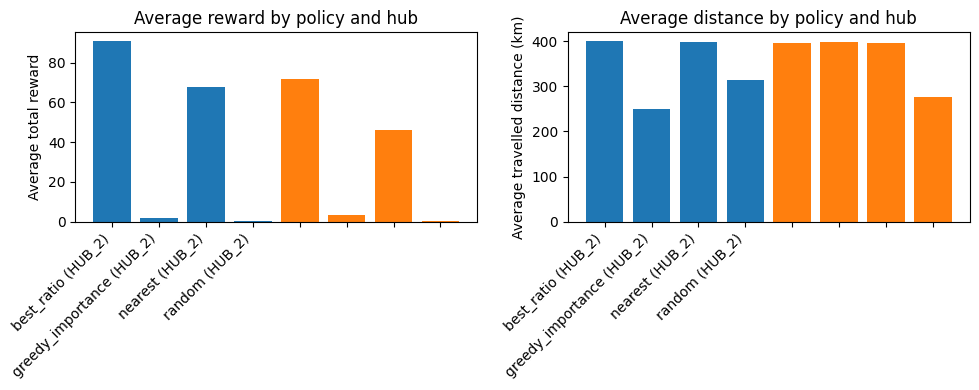

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for hub_id, group in summary_policies.groupby("hub_id"):
    ax = axes[0]
    ax.bar(
        group["policy"] + " (" + hub_id + ")",
        group["avg_reward"],
    )
    ax.set_ylabel("Average total reward")
    ax.set_xticklabels(group["policy"] + " (" + hub_id + ")", rotation=45, ha="right")

for hub_id, group in summary_policies.groupby("hub_id"):
    ax = axes[1]
    ax.bar(
        group["policy"] + " (" + hub_id + ")",
        group["avg_distance"],
    )
    ax.set_ylabel("Average travelled distance (km)")
    ax.set_xticklabels(group["policy"] + " (" + hub_id + ")", rotation=45, ha="right")

axes[0].set_title("Average reward by policy and hub")
axes[1].set_title("Average distance by policy and hub")

plt.tight_layout()
plt.show()

We choose for e.g. the route with best_ratio in HUB_1

In [18]:
example = (
    df_results[
        (df_results["hub_id"] == "HUB_1")
        & (df_results["policy"] == "best_ratio")
    ]
    .sort_values("total_reward", ascending=False)
    .iloc[0]
)

example

total_reward                                              90.756219
total_distance                                           399.960064
remaining_km                                               0.039936
n_visited                                                       380
path_indices      [37047, 20203, 10098, 35055, 3372, 5507, 37952...
hub_id                                                        HUB_1
policy                                                   best_ratio
seed                                                              0
Name: 20, dtype: object

In [19]:
# Reconstruimos la ruta para graficarla
env_example = ForagingEnv(
    df_customers=df_north,
    df_hubs=df_hubs,
    hub_id=example["hub_id"],
    distance_col=distance_col,
    budget_km=400.0,
)

env_example.reset()
for idx in example["path_indices"]:
    env_example.step(idx)

path_customers = env_example.customers.loc[example["path_indices"]]

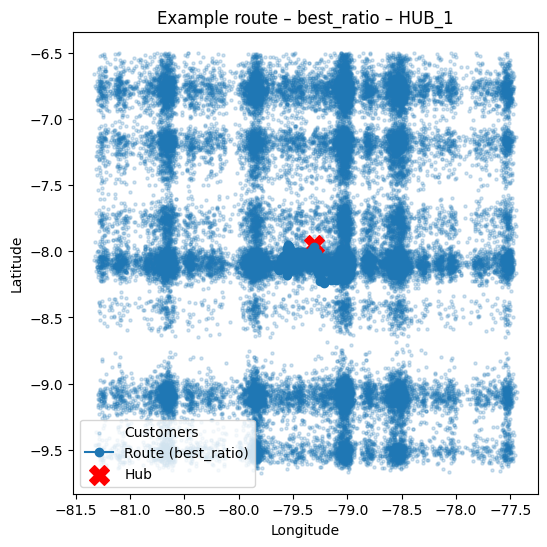

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))

# Todos los clientes del hub como puntos grises
customers_hub = df_north[df_north["assigned_hub"] == example["hub_id"]]
ax.scatter(customers_hub["LNGTUD"], customers_hub["LATTUD"], s=5, alpha=0.2, label="Customers")

# Ruta recorrida
ax.plot(
    path_customers["LNGTUD"],
    path_customers["LATTUD"],
    marker="o",
    linewidth=1.5,
    label=f"Route ({example['policy']})",
)

# Hub
hub_row = df_hubs[df_hubs["HUB_ID"] == example["hub_id"]].iloc[0]
ax.scatter(hub_row["LNGTUD"], hub_row["LATTUD"], s=200, marker="X", c="red", label="Hub")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Example route – {example['policy']} – {example['hub_id']}")
ax.legend()
plt.show()

## Summary

- A simple foraging environment was defined around each hub. The agent
  starts at the hub, has a limited travel budget (in km) and visits
  customers one by one, collecting their importance `w_importance` as
  reward.

- We compared four heuristic policies:
  - **nearest**: always visit the closest unvisited customer,
  - **greedy_importance**: always go to the customer with highest
    importance,
  - **best_ratio**: choose the customer with best importance-per-km
    ratio,
  - **random**: pick an unvisited customer at random (baseline).

- For each hub and each policy, multiple episodes were simulated. The
  results were summarised in terms of average total reward, distance
  travelled and number of visited customers.

- The example route visualisations show how different policies trace
  very different paths over the same hub–customer landscape, even though
  they all start from the same facility and face the same distance
  budget.

These simulations illustrate that hub placement is only one part of the
story. The operational policy used by field teams can significantly
change how much value is actually captured from the network.
